<a href="https://colab.research.google.com/github/SFarhan-dot/Detect-Retinal-Disease-Using-Optical-Coherence-Tomography-Images./blob/main/Proposed01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D

In [2]:
train_path ="/content/drive/MyDrive/Thesis/train"
test_path ="/content/drive/MyDrive/Thesis/test"
val_path ="/content/drive/MyDrive/Thesis/val"
test_ratio=0.2
val_ratio=0.2
image_size=(128,128,3)

In [3]:
myList = os.listdir(train_path)
print("Total Number of Classes Detected :",len(myList))

Total Number of Classes Detected : 4


In [4]:
print(myList)
noOfclasses= len(myList)

['NORMAL', 'CNV', 'DRUSEN', 'DME']


In [5]:
images=[]
classNo=[]
CATEGORIES = ['NORMAL',"CNV","DME","DRUSEN"]
for x in myList:
    myPicList = os.listdir(train_path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(train_path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(image_size[0],image_size[1]))
        images.append(curImg)
        classNo.append(CATEGORIES.index(x))
    print(x,end=" ")

NORMAL CNV DRUSEN DME 

In [6]:
x_test=[]
y_test=[]
CATEGORIES = ['NORMAL',"CNV","DME","DRUSEN"]
for x in myList:
    myPicList = os.listdir(test_path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(test_path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(image_size[0],image_size[1]))
        x_test.append(curImg)
        y_test.append(CATEGORIES.index(x))
    print(x,end=" ")

NORMAL CNV DRUSEN DME 

In [7]:
x_val=[]
y_val=[]
CATEGORIES = ['NORMAL',"CNV","DME","DRUSEN"]
for x in myList:
    myPicList = os.listdir(val_path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(val_path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(image_size[0],image_size[1]))
        x_val.append(curImg)
        y_val.append(CATEGORIES.index(x))
    print(x,end=" ")

NORMAL CNV DRUSEN DME 

In [8]:
print(len(images))
print(len(classNo))

14400
14400


In [9]:
x_train = np.array(images)
y_train = np.array(classNo)

In [10]:
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)

(14400, 128, 128, 3)
(968, 128, 128, 3)


In [12]:
del images
del classNo

In [13]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(14400, 128, 128, 3)
(968, 128, 128, 3)
(32, 128, 128, 3)


In [14]:
numofSamples=[]
for x in range(0,noOfclasses):
    numofSamples.append(len(np.where(y_train==x)[0]))
print(numofSamples)

[3438, 3840, 3714, 3408]


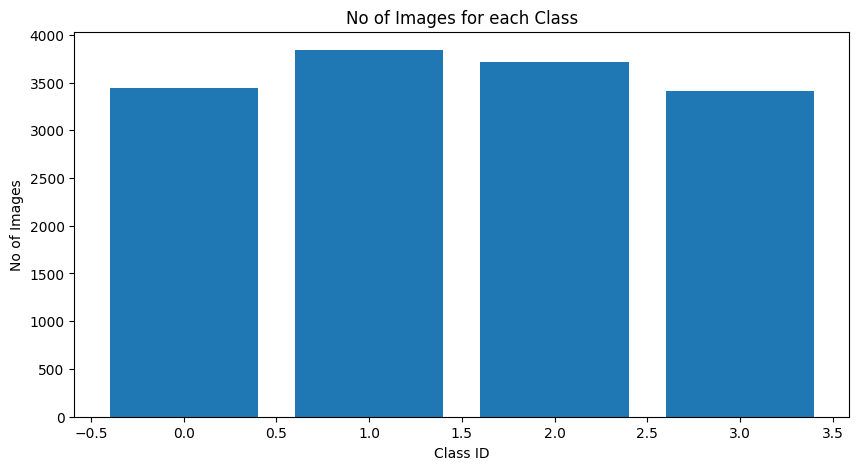

In [15]:
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfclasses),numofSamples)
plt.title('No of Images for each Class')
plt.xlabel("Class ID")
plt.ylabel("No of Images")
plt.show()

<Axes: ylabel='count'>

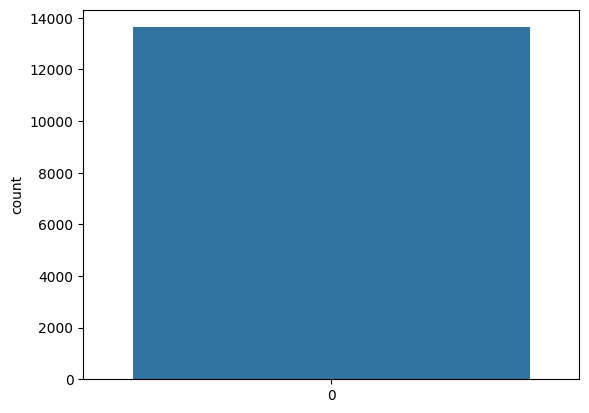

In [16]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import seaborn as sns
X_trainShape = x_train.shape[1]*x_train.shape[2]*x_train.shape[3]
X_trainFlat = x_train.reshape(x_train.shape[0], X_trainShape)
Y_train = y_train
ros = RandomUnderSampler()
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 4)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = image_size[0],image_size[1],3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
sns.countplot(labRos)

In [17]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

In [18]:
x_train = np.array(list(map(preProcessing,X_trainRosReshaped)))
print(x_train[0].shape)

(128, 128)


In [19]:
x_test = np.array(list(map(preProcessing,x_test)))
print(x_test[0].shape)

(128, 128)


In [20]:
x_validation = np.array(list(map(preProcessing,x_val)))
print(x_validation[0].shape)

(128, 128)


In [21]:
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
print(X_train.shape)

(13632, 128, 128, 1)


In [22]:
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
X_validation = x_validation.reshape(x_validation.shape[0],x_validation.shape[1],x_validation.shape[2],1)

In [23]:
del x_test
del x_train
del x_validation

In [24]:
y_train = to_categorical(Y_trainRos,noOfclasses)
y_test = to_categorical(y_test,noOfclasses)
y_validation = to_categorical(y_val,noOfclasses)

In [25]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];

        with open('log.txt','w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open('log.txt','a') as f:
            f.write('End of logging..\n')
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open('log.txt','a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open('log.txt','a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

In [26]:
def model():
    model = Sequential();
    model.add((Conv2D(60,(5,5),input_shape=(image_size[0],image_size[1],1)
    ,activation="relu")))

    model.add((Conv2D(60,(5,5),activation="relu")))
    model.add((Conv2D(60//2,(4,4),activation="relu")))
    model.add((Conv2D(60//2,(4,4),activation="relu")))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add((Conv2D(60,(5,5),activation="relu")))
    model.add((Conv2D(60//2,(4,4),activation="relu")))
    model.add((Conv2D(60//2,(4,4),activation="relu")))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add((Conv2D(60,(4,4),activation="relu")))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add((Conv2D(60//2,(3,3),activation="relu")))
    model.add((Conv2D(60//2,(3,3),activation="relu")))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(5000,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(noOfclasses,activation="softmax"))

    model.compile(Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])

    return model

model=model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 60)      1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 60)      90060     
                                                                 
 conv2d_2 (Conv2D)           (None, 117, 117, 30)      28830     
                                                                 
 conv2d_3 (Conv2D)           (None, 114, 114, 30)      14430     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 57, 57, 30)        0         
                                                        

In [27]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Epoch 1/50
  6/426 [..............................] - ETA: 45s - loss: 1.4771 - accuracy: 0.2917

426/426 [==============================] - 66s 110ms/step - loss: 1.1428 - accuracy: 0.4569 - val_loss: 0.7191 - val_accuracy: 0.7188
Epoch 2/50
426/426 [==============================] - 48s 112ms/step - loss: 0.9276 - accuracy: 0.6056 - val_loss: 0.5536 - val_accuracy: 0.8125
Epoch 3/50
426/426 [==============================] - 48s 113ms/step - loss: 0.7369 - accuracy: 0.7072 - val_loss: 0.4612 - val_accuracy: 0.8438
Epoch 4/50
426/426 [==============================] - 48s 113ms/step - loss: 0.5499 - accuracy: 0.7944 - val_loss: 0.1241 - val_accuracy: 0.9688
Epoch 5/50
426/426 [==============================] - 48s 112ms/step - loss: 0.4452 - accuracy: 0.8369 - val_loss: 0.1254 - val_accuracy: 0.9688
Epoch 6/50
426/426 [==============================] - 48s 112ms/step - loss: 0.3889 - accuracy: 0.8605 - val_loss: 0.1608 - val_accuracy: 0.9375
Epoch 7/50
426/426 [==============================] - 48s 112ms/step - loss: 0.3388 - accuracy: 0.8798 - val_loss: 0.1097 - val_accuracy: 0.9

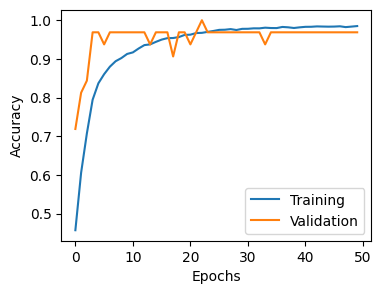

In [28]:
history = model.fit(X_train,Y_trainRosHot,epochs=50,validation_data =(X_validation,y_validation) ,batch_size=32,
                    shuffle=True,
                    max_queue_size=100,
                    use_multiprocessing=True,
                    workers=1,
                   callbacks=[CustomCallback(fraction=0.9)])

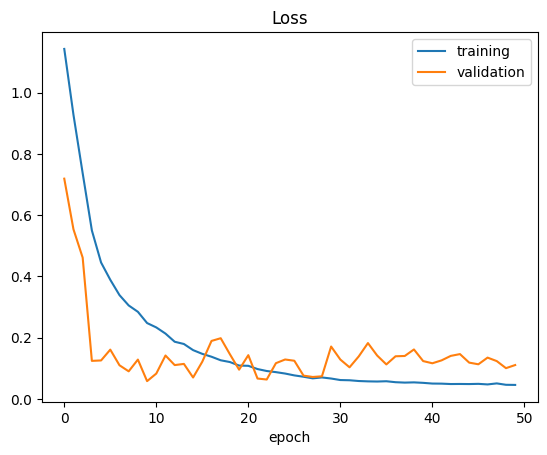

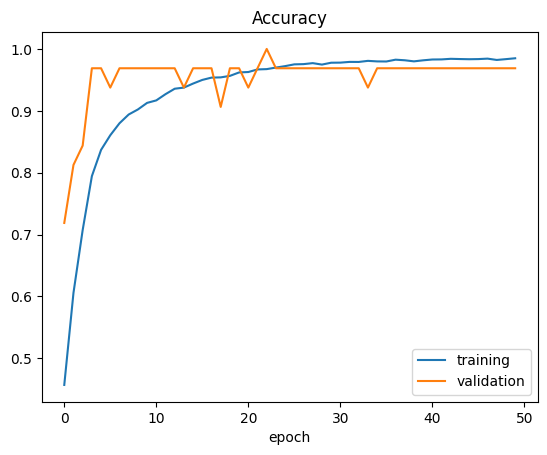

In [29]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [30]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy = ',score[1])
print('val_accuracy')

Test Score =  0.08851577341556549
Test Accuracy =  0.9834710955619812
val_accuracy
